# Evolutionary History
#### Do all certain tracrRNA structural families appear in different environments together or does it follow more of a species model?
#### How do the cas9/tracrRNA pairs compare across environments?

In [1]:
%matplotlib inline
import pandas as pd
from Bio.SeqIO import parse
from pandas import Series

tracrHits = pd.read_csv("data/CombinedTracr.blastout_dustno",delimiter="\t")
#Add qseqid's original length
tracrMap = {}
for rec in parse("data/TracrRNAs.fa","fasta"): tracrMap[rec.id]=len(rec.seq)*0.75
tracrHits["q_length"] = tracrHits["qseqid"].map(tracrMap)
tracrHits.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,q_length
0,NZ_NDGA01000017.1_ORF1,k87_11656578_manure,88.095,42,5,0,63,104,74,115,0.000214,51.0,78.0
1,NZ_NDGA01000017.1_ORF1,k87_5723229_manure,86.957,46,5,1,60,104,3808,3853,0.000214,51.0,78.0
2,NZ_NDGA01000017.1_ORF1,k87_368414_soil,95.652,23,1,0,50,72,2090,2112,1.700000,38.1,78.0
3,NZ_NDGA01000017.1_ORF1,k87_4643681_manure,95.652,23,1,0,66,88,144,122,1.700000,38.1,78.0
4,NZ_NDGA01000017.1_ORF1,k87_3463353_manure,92.308,26,2,0,15,40,5767,5792,1.700000,38.1,78.0


In [2]:
print "Number of hits before filtering:", "{:,}".format(len(tracrHits))
tracrHits = tracrHits[tracrHits.length>=tracrHits.q_length]
print "Remaining hits:", "{:,}".format(len(tracrHits))

Number of hits before filtering: 185,729
Remaining hits: 2,395


In [3]:
abundance = pd.read_csv("data/counts.tsv",delimiter="\t")
print "Number of unique tracrs Found:",len(tracrHits.sseqid.unique())

Number of unique tracrs Found: 131


In [4]:
#Average of the 6 soil and 6 manure sample counts 
abundance["ManureTotal"] = (abundance["M1_S1_L001"] + abundance["M1_S1_L003"]+ abundance["M1_S1_L004"]+ abundance["M2_S2_L001"]+ abundance["M2_S2_L003"]+ abundance["M2_S2_L004"])/6.0
abundance["SoilTotal"] = (abundance["S1_S3_L003"] + abundance["S1_S3_L004"]+ abundance["S1_S99_L004"]+ abundance["S2_S100_L004"]+ abundance["S2_S4_L003"]+ abundance["S2_S4_L004"])/6.0
abundance.head()

,ID,M1_S1_L001,M1_S1_L003,M1_S1_L004,M2_S2_L001,M2_S2_L003,M2_S2_L004,S1_S3_L003,S1_S3_L004,S1_S99_L004,S2_S100_L004,S2_S4_L003,S2_S4_L004,ManureTotal,SoilTotal
0,k87_8447395_manure,35,12,13,20,5,8,0,0,0,0,0,0,15.500000,0.0
1,k87_3519059_soil,0,0,0,0,0,0,0,3,0,1,2,3,0.000000,1.5
2,k87_10590011_soil,0,0,0,0,0,0,1,4,5,8,3,6,0.000000,4.5
3,k87_4355985_manure,2,2,0,0,0,0,0,0,0,0,0,0,0.666667,0.0
4,k87_3574396_soil,0,0,0,0,0,0,0,0,0,10,3,5,0.000000,3.0


In [5]:
abdCount = len(abundance)
print "Total Contigs:", "{:,}".format(abdCount)
abundance = abundance[~((abundance.SoilTotal<=1) & (abundance.ManureTotal <= 1))]
print "# Contigs in neither:", "{:,}".format(abdCount - len(abundance))
soilOnly = abundance[(abundance.SoilTotal>1) & (abundance.ManureTotal < 1)]
manureOnly = abundance[(abundance.SoilTotal<1) & (abundance.ManureTotal > 1)]
both = abundance[(abundance.SoilTotal>1) & (abundance.ManureTotal>1)]
neither = abundance[(abundance.SoilTotal<1) & (abundance.ManureTotal < 1)]
print "# Contigs only in Soil:","{:,}".format(len(soilOnly))
print "# Contigs only in Manure:","{:,}".format(len(manureOnly))
print "# Contigs only in Both:","{:,}".format(len(both))


Total Contigs: 13,285,680
# Contigs in neither: 4,259,733
# Contigs only in Soil: 6,454,632
# Contigs only in Manure: 2,562,754
# Contigs only in Both: 6,053


In [6]:
soilTracrs   = set(tracrHits[tracrHits.sseqid.isin(soilOnly.ID)].qseqid)
manureTracrs = set(tracrHits[tracrHits.sseqid.isin(manureOnly.ID)].qseqid)
tracrsInBoth = soilTracrs.intersection(manureTracrs)
print "# of unique TRACRs in the soil contigs:", len(soilTracrs)
print "# of unique TRACRs in the manure contigs:", len(manureTracrs)
print "Tracr in both:", len(tracrsInBoth)
print "Only in soil:", len(soilTracrs.difference(manureTracrs))
print "Only in manure:", len(manureTracrs.difference(soilTracrs))

# of unique TRACRs in the soil contigs: 19
# of unique TRACRs in the manure contigs: 385
Tracr in both: 19
Only in soil: 0
Only in manure: 366


In [8]:
soilAbundance, manureAbundance = 0,0
dist = []
fh = open("AbundanceData.txt","w")
fh.write("%s\t%s\t%s\t%s\n" % ("ID","ManureCount","SoilCount","Difference"))
for tracrName in tracrsInBoth:
    hits = tracrHits[tracrHits.qseqid == tracrName]
    abundanceHits = abundance[abundance.ID.isin(hits.sseqid.unique())]
    manureSum, soilSum = abundanceHits.ManureTotal.sum(), abundanceHits.SoilTotal.sum()
    fh.write("%s\t%i\t%i\t%i\n" % (tracrName,manureSum,soilSum,manureSum-soilSum))
    dist.append(manureSum-soilSum)
    manureAbundance += manureSum
    soilAbundance += soilSum
from pandas import Series
dist = Series(dist)
fh.close()

count     19.000000
mean     110.885965
std       46.620448
min        1.333333
25%       99.083333
50%      114.833333
75%      149.083333
max      158.000000
dtype: float64


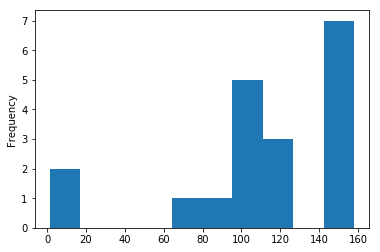

In [9]:
dist.plot.hist();
print dist.describe()

In [10]:
dist[dist<0]

Series([], dtype: float64)

In [11]:
dist[dist<10]

5     1.333333
17    6.333333
dtype: float64